# AeroClub RecSys 2025 - XGBoost Ranking Baseline

This notebook implements an improved ranking approach using XGBoost and Polars for the AeroClub recommendation challenge.

In [1]:
%%capture
!pip install -U xgboost
!pip install -U polars

In [2]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import time
import xgboost as xgb

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
# Load data
train = pl.read_parquet('/kaggle/input/aeroclub-recsys-2025/train.parquet').drop('__index_level_0__')
test = pl.read_parquet('/kaggle/input/aeroclub-recsys-2025/test.parquet').drop('__index_level_0__').with_columns(pl.lit(0, dtype=pl.Int64).alias("selected"))

data_raw = pl.concat((train, test))

## Helpers

In [4]:
def hitrate_at_3(y_true, y_pred, groups):
    df = pl.DataFrame({
        'group': groups,
        'pred': y_pred,
        'true': y_true
    })
    
    return (
        df.filter(pl.col("group").count().over("group") > 10)
        .sort(["group", "pred"], descending=[False, True])
        .group_by("group", maintain_order=True)
        .head(3)
        .group_by("group")
        .agg(pl.col("true").max())
        .select(pl.col("true").mean())
        .item()
    )

## Feature Engineering

In [5]:
df = data_raw.clone()

# More efficient duration to minutes converter
def dur_to_min(col):
    # Extract days and time parts in one pass
    days = col.str.extract(r"^(\d+)\.", 1).cast(pl.Int64).fill_null(0) * 1440
    time_str = pl.when(col.str.contains(r"^\d+\.")).then(col.str.replace(r"^\d+\.", "")).otherwise(col)
    hours = time_str.str.extract(r"^(\d+):", 1).cast(pl.Int64).fill_null(0) * 60
    minutes = time_str.str.extract(r":(\d+):", 1).cast(pl.Int64).fill_null(0)
    return (days + hours + minutes).fill_null(0)

# Process duration columns
dur_cols = ["legs0_duration", "legs1_duration"] + [f"legs{l}_segments{s}_duration" for l in (0, 1) for s in (0, 1)]
dur_exprs = [dur_to_min(pl.col(c)).alias(c) for c in dur_cols if c in df.columns]

# Apply duration transformations first
if dur_exprs:
    df = df.with_columns(dur_exprs)

# Precompute marketing carrier columns check
mc_cols = [f'legs{l}_segments{s}_marketingCarrier_code' for l in (0, 1) for s in range(4)]
mc_exists = [col for col in mc_cols if col in df.columns]

# Combine all initial transformations
df = df.with_columns([
        # Price features
        (pl.col("totalPrice") / (pl.col("taxes") + 1)).alias("price_per_tax"),
        (pl.col("taxes") / (pl.col("totalPrice") + 1)).alias("tax_rate"),
        pl.col("totalPrice").log1p().alias("log_price"),
        
        # Duration features
        (pl.col("legs0_duration").fill_null(0) + pl.col("legs1_duration").fill_null(0)).alias("total_duration"),
        pl.when(pl.col("legs1_duration").fill_null(0) > 0)
            .then(pl.col("legs0_duration") / (pl.col("legs1_duration") + 1))
            .otherwise(1.0).alias("duration_ratio"),
        
        # Trip type
        (pl.col("legs1_duration").is_null() | 
         (pl.col("legs1_duration") == 0) | 
         pl.col("legs1_segments0_departureFrom_airport_iata").is_null()).cast(pl.Int32).alias("is_one_way"),
        
        # Total segments count
        (pl.sum_horizontal(pl.col(col).is_not_null().cast(pl.UInt8) for col in mc_exists) 
         if mc_exists else pl.lit(0)).alias("l0_seg"),
        
        # FF features
        (pl.col("frequentFlyer").fill_null("").str.count_matches("/") + 
         (pl.col("frequentFlyer").fill_null("") != "").cast(pl.Int32)).alias("n_ff_programs"),
        
        # Binary features
        pl.col("corporateTariffCode").is_not_null().cast(pl.Int32).alias("has_corporate_tariff"),
        (pl.col("pricingInfo_isAccessTP") == 1).cast(pl.Int32).alias("has_access_tp"),
        
        # Baggage & fees
        (pl.col("legs0_segments0_baggageAllowance_quantity").fill_null(0) + 
         pl.col("legs1_segments0_baggageAllowance_quantity").fill_null(0)).alias("baggage_total"),
        (pl.col("miniRules0_monetaryAmount").fill_null(0) + 
         pl.col("miniRules1_monetaryAmount").fill_null(0)).alias("total_fees"),
        
        # Routes & carriers
        pl.col("searchRoute").is_in(["MOWLED/LEDMOW", "LEDMOW/MOWLED", "MOWLED", "LEDMOW", "MOWAER/AERMOW"])
            .cast(pl.Int32).alias("is_popular_route"),
        
        # Cabin
        pl.mean_horizontal(["legs0_segments0_cabinClass", "legs1_segments0_cabinClass"]).alias("avg_cabin_class"),
        (pl.col("legs0_segments0_cabinClass").fill_null(0) - 
         pl.col("legs1_segments0_cabinClass").fill_null(0)).alias("cabin_class_diff"),
])

# Segment counts - more efficient
seg_exprs = []
for leg in (0, 1):
    seg_cols = [f"legs{leg}_segments{s}_duration" for s in range(4) if f"legs{leg}_segments{s}_duration" in df.columns]
    if seg_cols:
        seg_exprs.append(
            pl.sum_horizontal(pl.col(c).is_not_null() for c in seg_cols)
                .cast(pl.Int32).alias(f"n_segments_leg{leg}")
        )
    else:
        seg_exprs.append(pl.lit(0).cast(pl.Int32).alias(f"n_segments_leg{leg}"))

# Add segment-based features
# First create segment counts
df = df.with_columns(seg_exprs)

# Then use them for derived features
df = df.with_columns([
    (pl.col("n_segments_leg0") + pl.col("n_segments_leg1")).alias("total_segments"),
    (pl.col("n_segments_leg0") == 1).cast(pl.Int32).alias("is_direct_leg0"),
    pl.when(pl.col("is_one_way") == 1).then(0)
        .otherwise((pl.col("n_segments_leg1") == 1).cast(pl.Int32)).alias("is_direct_leg1"),
])

# More derived features
df = df.with_columns([
    (pl.col("is_direct_leg0") & pl.col("is_direct_leg1")).cast(pl.Int32).alias("both_direct"),
    ((pl.col("isVip") == 1) | (pl.col("n_ff_programs") > 0)).cast(pl.Int32).alias("is_vip_freq"),
    (pl.col("baggage_total") > 0).cast(pl.Int32).alias("has_baggage"),
    (pl.col("total_fees") > 0).cast(pl.Int32).alias("has_fees"),
    (pl.col("total_fees") / (pl.col("totalPrice") + 1)).alias("fee_rate"),
    pl.col("Id").count().over("ranker_id").alias("group_size"),
])

# Add major carrier flag if column exists
if "legs0_segments0_marketingCarrier_code" in df.columns:
    df = df.with_columns(
        pl.col("legs0_segments0_marketingCarrier_code").is_in(["SU", "S7", "U6"])
            .cast(pl.Int32).alias("is_major_carrier")
    )
else:
    df = df.with_columns(pl.lit(0).alias("is_major_carrier"))

df = df.with_columns(pl.col("group_size").log1p().alias("group_size_log"))

# Time features - batch process
time_exprs = []
for col in ("legs0_departureAt", "legs0_arrivalAt", "legs1_departureAt", "legs1_arrivalAt"):
    if col in df.columns:
        dt = pl.col(col).str.to_datetime(strict=False)
        h = dt.dt.hour().fill_null(12)
        time_exprs.extend([
            h.alias(f"{col}_hour"),
            dt.dt.weekday().fill_null(0).alias(f"{col}_weekday"),
            (((h >= 6) & (h <= 9)) | ((h >= 17) & (h <= 20))).cast(pl.Int32).alias(f"{col}_business_time")
        ])
if time_exprs:
    df = df.with_columns(time_exprs)

# Batch rank computations - more efficient with single pass
# First apply the columns that will be used for ranking
df = df.with_columns([
    pl.col("group_size").log1p().alias("group_size_log"),
])

# Price and duration basic ranks
rank_exprs = []
for col, alias in [("totalPrice", "price"), ("total_duration", "duration")]:
    rank_exprs.append(pl.col(col).rank().over("ranker_id").alias(f"{alias}_rank"))

# Price-specific features
price_exprs = [
    (pl.col("totalPrice").rank("average").over("ranker_id") / 
     pl.col("totalPrice").count().over("ranker_id")).alias("price_pct_rank"),
    (pl.col("totalPrice") == pl.col("totalPrice").min().over("ranker_id")).cast(pl.Int32).alias("is_cheapest"),
    ((pl.col("totalPrice") - pl.col("totalPrice").median().over("ranker_id")) / 
     (pl.col("totalPrice").std().over("ranker_id") + 1)).alias("price_from_median"),
    (pl.col("l0_seg") == pl.col("l0_seg").min().over("ranker_id")).cast(pl.Int32).alias("is_min_segments"),
]

# Apply initial ranks
df = df.with_columns(rank_exprs + price_exprs)

# Cheapest direct - more efficient
direct_cheapest = (
    df.filter(pl.col("is_direct_leg0") == 1)
    .group_by("ranker_id")
    .agg(pl.col("totalPrice").min().alias("min_direct"))
)

df = df.join(direct_cheapest, on="ranker_id", how="left").with_columns(
    ((pl.col("is_direct_leg0") == 1) & 
     (pl.col("totalPrice") == pl.col("min_direct"))).cast(pl.Int32).fill_null(0).alias("is_direct_cheapest")
).drop("min_direct")

In [6]:
# Fill nulls
data = df.with_columns(
    [pl.col(c).fill_null(0) for c in df.select(pl.selectors.numeric()).columns] +
    [pl.col(c).fill_null("missing") for c in df.select(pl.selectors.string()).columns]
)

## Feature Selection

In [7]:
# Categorical features
cat_features = [
    'nationality', 'searchRoute', 'corporateTariffCode',
    'bySelf', 'sex', 'companyID',
    # Leg 0 segments 0-1
    'legs0_segments0_aircraft_code', 'legs0_segments0_arrivalTo_airport_city_iata',
    'legs0_segments0_arrivalTo_airport_iata', 'legs0_segments0_departureFrom_airport_iata',
    'legs0_segments0_marketingCarrier_code', 'legs0_segments0_operatingCarrier_code',
    'legs0_segments0_flightNumber',
    'legs0_segments1_aircraft_code', 'legs0_segments1_arrivalTo_airport_city_iata',
    'legs0_segments1_arrivalTo_airport_iata', 'legs0_segments1_departureFrom_airport_iata',
    'legs0_segments1_marketingCarrier_code', 'legs0_segments1_operatingCarrier_code',
    'legs0_segments1_flightNumber',
    # Leg 1 segments 0-1
    'legs1_segments0_aircraft_code', 'legs1_segments0_arrivalTo_airport_city_iata',
    'legs1_segments0_arrivalTo_airport_iata', 'legs1_segments0_departureFrom_airport_iata',
    'legs1_segments0_marketingCarrier_code', 'legs1_segments0_operatingCarrier_code',
    'legs1_segments0_flightNumber',
    'legs1_segments1_aircraft_code', 'legs1_segments1_arrivalTo_airport_city_iata',
    'legs1_segments1_arrivalTo_airport_iata', 'legs1_segments1_departureFrom_airport_iata',
    'legs1_segments1_marketingCarrier_code', 'legs1_segments1_operatingCarrier_code',
    'legs1_segments1_flightNumber',
]

# Columns to exclude (uninformative or problematic)
exclude_cols = [
    'Id', 'ranker_id', 'selected', 'profileId', 'requestDate',
    'legs0_departureAt', 'legs0_arrivalAt', 'legs1_departureAt', 'legs1_arrivalAt',
    'miniRules0_percentage', 'miniRules1_percentage',  # >90% missing
    'frequentFlyer',  # Already processed
    # Exclude constant columns
    'pricingInfo_passengerCount'
]


# Exclude segment 2-3 columns (>98% missing)
for leg in [0, 1]:
    for seg in [2, 3]:
        for suffix in ['aircraft_code', 'arrivalTo_airport_city_iata', 'arrivalTo_airport_iata',
                      'baggageAllowance_quantity', 'baggageAllowance_weightMeasurementType',
                      'cabinClass', 'departureFrom_airport_iata', 'duration', 'flightNumber',
                      'marketingCarrier_code', 'operatingCarrier_code', 'seatsAvailable']:
            exclude_cols.append(f'legs{leg}_segments{seg}_{suffix}')

feature_cols = [col for col in data.columns if col not in exclude_cols]
cat_features_final = [col for col in cat_features if col in feature_cols]

print(f"Using {len(feature_cols)} features ({len(cat_features_final)} categorical)")

X = data.select(feature_cols)
y = data.select('selected')
groups = data.select('ranker_id')

Using 112 features (34 categorical)


## Model Training

In [8]:
data_xgb = X.with_columns([(pl.col(c).rank("dense") - 1).fill_null(-1).cast(pl.Int32) for c in cat_features_final])

n1 = 16487352 # split train to train and val (10%) in time
n2 = train.height
data_xgb_tr, data_xgb_va, data_xgb_te = data_xgb[:n1], data_xgb[n1:n2], data_xgb[n2:]
y_tr, y_va, y_te = y[:n1], y[n1:n2], y[n2:]
groups_tr, groups_va, groups_te = groups[:n1], groups[n1:n2], groups[n2:]

group_sizes_tr = groups_tr.group_by('ranker_id').agg(pl.len()).sort('ranker_id')['len'].to_numpy()
group_sizes_va = groups_va.group_by('ranker_id').agg(pl.len()).sort('ranker_id')['len'].to_numpy()
group_sizes_te = groups_te.group_by('ranker_id').agg(pl.len()).sort('ranker_id')['len'].to_numpy()
dtrain = xgb.DMatrix(data_xgb_tr, label=y_tr, group=group_sizes_tr, feature_names=data_xgb.columns)
dval   = xgb.DMatrix(data_xgb_va, label=y_va, group=group_sizes_va, feature_names=data_xgb.columns)
dtest  = xgb.DMatrix(data_xgb_te, label=y_te, group=group_sizes_te, feature_names=data_xgb.columns)

In [9]:
# XGBoost parameters
xgb_params = {
    'objective': 'rank:pairwise',
    'eval_metric': 'ndcg@3',
    'max_depth': 10,
    'min_child_weight': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 10.0,
    'learning_rate': 0.06,
    'seed': RANDOM_STATE,
    'n_jobs': -1,
    # 'device': 'cuda'
}

# Train XGBoost model
print("Training XGBoost model...")
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=1500,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=100,
    verbose_eval=50
)

Training XGBoost model...
[0]	train-ndcg@3:0.78829	val-ndcg@3:0.80988
[50]	train-ndcg@3:0.83428	val-ndcg@3:0.83729
[100]	train-ndcg@3:0.84562	val-ndcg@3:0.84062
[150]	train-ndcg@3:0.85738	val-ndcg@3:0.84178
[200]	train-ndcg@3:0.86804	val-ndcg@3:0.84358
[250]	train-ndcg@3:0.87739	val-ndcg@3:0.84423
[300]	train-ndcg@3:0.88511	val-ndcg@3:0.84427
[350]	train-ndcg@3:0.89134	val-ndcg@3:0.84494
[400]	train-ndcg@3:0.89701	val-ndcg@3:0.84506
[450]	train-ndcg@3:0.90177	val-ndcg@3:0.84578
[499]	train-ndcg@3:0.90619	val-ndcg@3:0.84621


In [10]:
# Evaluate XGBoost
xgb_va_preds = xgb_model.predict(dval)
xgb_hr3 = hitrate_at_3(y_va, xgb_va_preds, groups_va)
print(f"HitRate@3: {xgb_hr3:.3f}")

HitRate@3: 0.505


In [11]:
xgb_importance = xgb_model.get_score(importance_type='gain')
xgb_importance_df = pl.DataFrame(
    [{'feature': k, 'importance': v} for k, v in xgb_importance.items()]
).sort('importance', descending=bool(1))
print(xgb_importance_df.head(20).to_pandas().to_string())

                                                   feature  importance
0                                          is_min_segments  321.290955
1                                            duration_rank   56.150616
2                                         is_popular_route   50.509991
3                               legs0_segments0_cabinClass   31.744341
4                legs0_segments0_baggageAllowance_quantity   28.453512
5                                               price_rank   28.255564
6                                                 has_fees   27.012461
7                                         is_major_carrier   23.782108
8                                miniRules1_monetaryAmount   21.814795
9                                          avg_cabin_class   19.768919
10                                  pricingInfo_isAccessTP   18.448168
11                                              total_fees   18.402351
12                                           has_access_tp   18.199781
13  le

## Error analysis and visualization

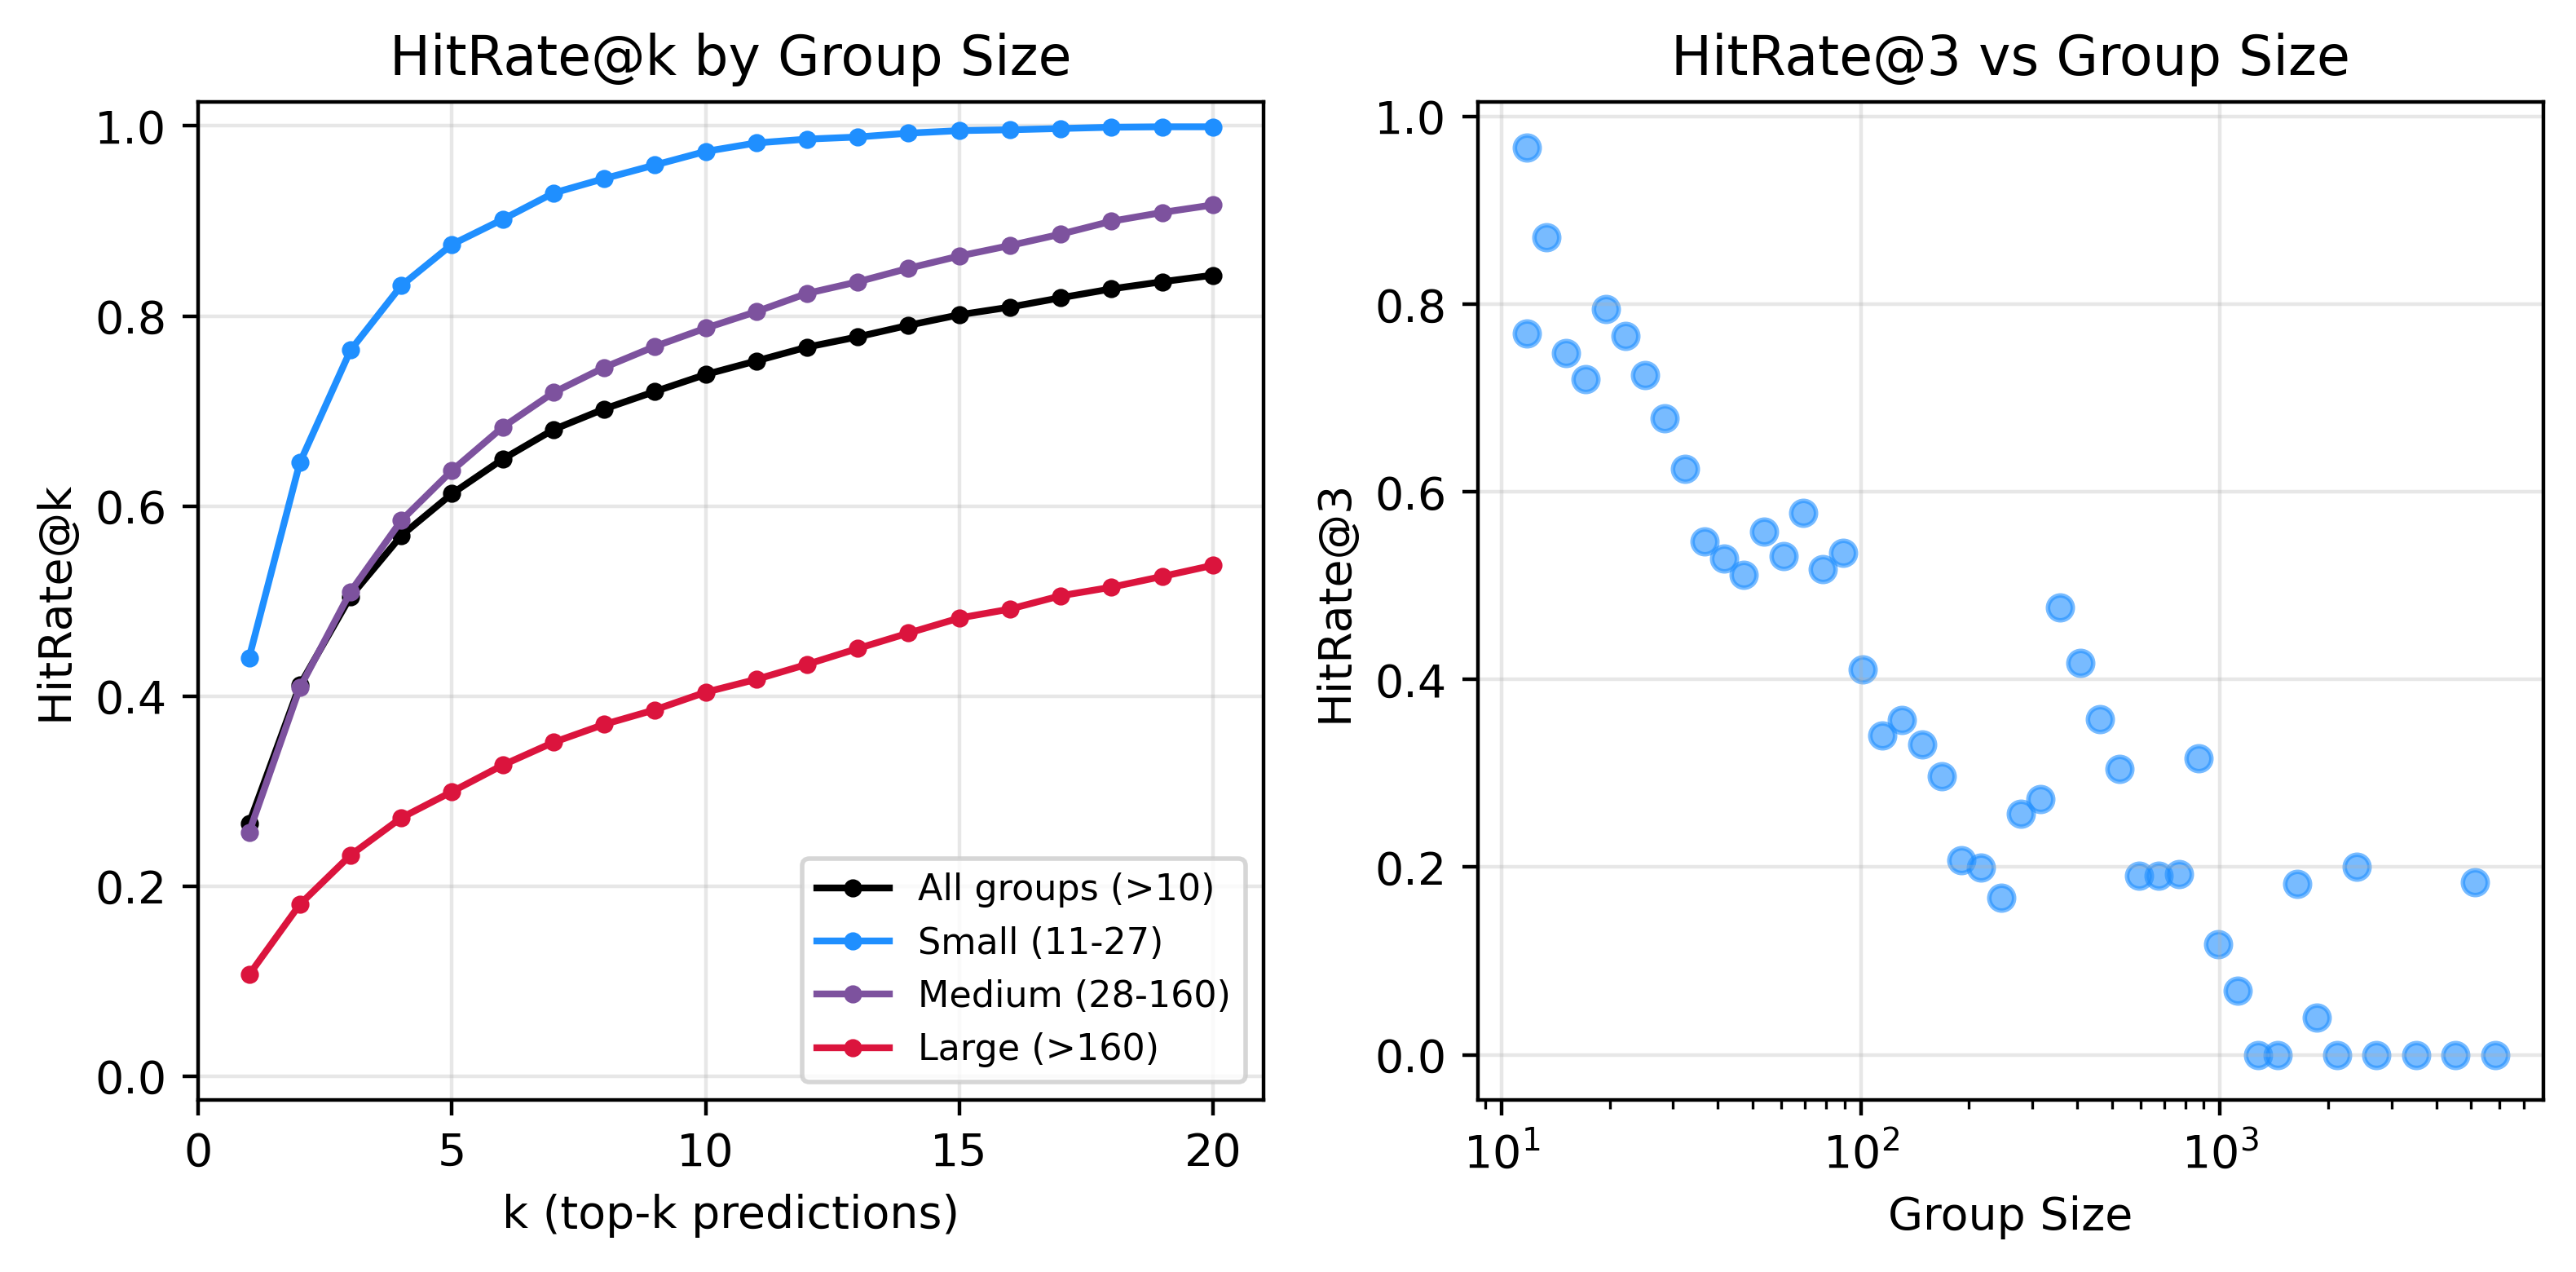

In [12]:
# Color palette
red = (0.86, 0.08, 0.24)
blue = (0.12, 0.56, 1.0)

# Prepare data for analysis
va_df = pl.DataFrame({
    'ranker_id': groups_va.to_numpy().flatten(),
    'pred_score': xgb_va_preds,
    'selected': y_va.to_numpy().flatten()
})

# Add group size and filter
va_df = va_df.join(
    va_df.group_by('ranker_id').agg(pl.len().alias('group_size')), 
    on='ranker_id'
).filter(pl.col('group_size') > 10)

# Calculate group size quantiles
size_quantiles = va_df.select('ranker_id', 'group_size').unique().select(
    pl.col('group_size').quantile(0.25).alias('q25'),
    pl.col('group_size').quantile(0.50).alias('q50'),
    pl.col('group_size').quantile(0.75).alias('q75')
).to_dicts()[0]

# Function to calculate hitrate curve efficiently
def calculate_hitrate_curve(df, k_values):
    # Sort once and calculate all k values
    sorted_df = df.sort(["ranker_id", "pred_score"], descending=[False, True])
    return [
        sorted_df.group_by("ranker_id", maintain_order=True)
        .head(k)
        .group_by("ranker_id")
        .agg(pl.col("selected").max().alias("hit"))
        .select(pl.col("hit").mean())
        .item()
        for k in k_values
    ]

# Calculate curves
k_values = list(range(1, 21))
curves = {
    'All groups (>10)': calculate_hitrate_curve(va_df, k_values),
    f'Small (11-{int(size_quantiles["q25"])})': calculate_hitrate_curve(
        va_df.filter(pl.col('group_size') <= size_quantiles['q25']), k_values
    ),
    f'Medium ({int(size_quantiles["q25"]+1)}-{int(size_quantiles["q75"])})': calculate_hitrate_curve(
        va_df.filter((pl.col('group_size') > size_quantiles['q25']) & 
                    (pl.col('group_size') <= size_quantiles['q75'])), k_values
    ),
    f'Large (>{int(size_quantiles["q75"])})': calculate_hitrate_curve(
        va_df.filter(pl.col('group_size') > size_quantiles['q75']), k_values
    )
}

# Calculate hitrate@3 by group size using log-scale bins
# Create log-scale bins
min_size = va_df['group_size'].min()
max_size = va_df['group_size'].max()
bins = np.logspace(np.log10(min_size), np.log10(max_size), 51)  # 51 edges = 50 bins

# Calculate hitrate@3 for each ranker_id
ranker_hr3 = (
    va_df.sort(["ranker_id", "pred_score"], descending=[False, True])
    .group_by("ranker_id", maintain_order=True)
    .agg([
        pl.col("selected").head(3).max().alias("hit_top3"),
        pl.col("group_size").first()
    ])
)

# Assign bins and calculate hitrate per bin
bin_centers = (bins[:-1] + bins[1:]) / 2  # Geometric mean would be more accurate for log scale
bin_indices = np.digitize(ranker_hr3['group_size'].to_numpy(), bins) - 1

size_analysis = pl.DataFrame({
    'bin_idx': bin_indices,
    'bin_center': bin_centers[np.clip(bin_indices, 0, len(bin_centers)-1)],
    'hit_top3': ranker_hr3['hit_top3']
}).group_by(['bin_idx', 'bin_center']).agg([
    pl.col('hit_top3').mean().alias('hitrate3'),
    pl.len().alias('n_groups')
]).filter(pl.col('n_groups') >= 3).sort('bin_center')  # At least 3 groups per bin

# Create combined figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), dpi=400)

# Left plot: HitRate@k curves
# Create color gradient from blue to red for size groups
colors = ['black']  # All groups is black
for i in range(3):  # 3 size groups
    t = i / 2  # 0, 0.5, 1
    color = tuple(blue[j] * (1 - t) + red[j] * t for j in range(3))
    colors.append(color)

for (label, hitrates), color in zip(curves.items(), colors):
    ax1.plot(k_values, hitrates, marker='o', label=label, color=color, markersize=3)
ax1.set_xlabel('k (top-k predictions)')
ax1.set_ylabel('HitRate@k')
ax1.set_title('HitRate@k by Group Size')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 21)
ax1.set_ylim(-0.025, 1.025)

# Right plot: HitRate@3 vs Group Size (log scale)
ax2.scatter(size_analysis['bin_center'], size_analysis['hitrate3'], s=30, alpha=0.6, color=blue)
ax2.set_xlabel('Group Size')
ax2.set_ylabel('HitRate@3')
ax2.set_title('HitRate@3 vs Group Size')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# Summary
print(f"HitRate@1: {curves['All groups (>10)'][0]:.3f}")
print(f"HitRate@3: {curves['All groups (>10)'][2]:.3f}")
print(f"HitRate@5: {curves['All groups (>10)'][4]:.3f}")
print(f"HitRate@10: {curves['All groups (>10)'][9]:.3f}")

HitRate@1: 0.266
HitRate@3: 0.505
HitRate@5: 0.613
HitRate@10: 0.738


## Submission

In [14]:
submission_xgb = (
    test.select(['Id', 'ranker_id'])
    .with_columns(pl.Series('pred_score', xgb_model.predict(dtest)))
    .with_columns(
        pl.col('pred_score')
        .rank(method='ordinal', descending=True)
        .over('ranker_id')
        .cast(pl.Int32)
        .alias('selected')
    )
    .select(['Id', 'ranker_id', 'selected'])
)
submission_xgb.write_csv('submission.csv')